# Data Analysis Plan: Stock Price Predictor

## Team 17: 
- Forrest Meng 
- Michael Kim

## Project Goal:
This work will apply machine learning techniques on historical data of many company's performance and stock prices. It will use this regression analysis to predict the future peformance of a company's stock based on it's lasted performance indicators. 

# Data:

## Overview:
We will use two sources of data:

### 1. Historical Stock Prices

We can use [this python script from Kaggle](https://www.kaggle.com/jacksoncrow/download-nasdaq-historical-data) to download historical stock price data for all NASDAQ traded companies. This script uses the yfinance library, which is a market data downloader. This gives us data for each stock's price from when the company first went public up until now.

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, date

ticker = yf.Ticker('aapl')
df_prices = ticker.history(period='max')
del df_prices['Dividends']
del df_prices['Stock Splits']
del df_prices['Volume']

df_prices = df_prices.sort_values(by='Date', ascending=False)
df_prices = df_prices.reset_index()
df_prices['Date'] =  pd.to_datetime(df_prices['Date'], format= '%Y-%m-%d')

# our company performance data begins on 5/31/2005 (Q1)
df_prices = df_prices[df_prices['Date'] >= pd.Timestamp(2005, 1, 1)]

df_prices = df_prices.set_index('Date')
df_prices = df_prices.resample('QS').mean()
df_prices = df_prices.reset_index()
df_prices['Date'] = pd.PeriodIndex(df_prices['Date'], freq='Q')
df_prices

,Date,Open,High,Low,Close
0,2005Q1,1.218315,1.235116,1.197643,1.216242
1,2005Q2,1.167599,1.184894,1.147450,1.165201
2,2005Q3,1.400802,1.421485,1.385324,1.406459
3,2005Q4,1.949157,1.976902,1.923238,1.953464
4,2006Q1,2.170869,2.205076,2.125047,2.158306
...,...,...,...,...,...
61,2020Q2,76.781456,77.871486,75.936893,77.025626
62,2020Q3,108.846901,110.408596,106.847904,108.693556
63,2020Q4,120.044865,121.539177,118.528336,120.020785
64,2021Q1,128.537355,129.996851,126.591154,128.282984


### 2. Company Performance Indicators

We can scrape historical performance indicators for a specific company from [www.macrotrends.net](https://www.macrotrends.net). Macrotrends offers many indicators includings ones on assets, liabilities, revenues, ratios, and vraious others. Macrotrends has quarterly data from Q1 2005 to Q4 2020. 

### Pipeline Overview

We will accomplish this task with three functions:
- `get_url()`
    - returns html string of a given url
- `clean_quarterly()`
    - builds dataframe of given metric (column) for each quarter (row) from html string
- `get_metrics()`
    - recurs calls of get_url() and clean_quarterly() and concats returned dataframes 
        to get one dataframe with many metrics (columns)
    - pass a list of metrics, and company name and ticker
    
### Pipeline

In [2]:
def get_url(url):
    """ returns the html of the webpage
    
    Args:
        url (str): url
        
    Returns:
        html_str (str): html response
    """
    response = requests.get(url)
    return response.text

In [3]:
def clean_quarterly(html_str, metric):
    """ extracts metric data from html_str and build a df with it
    
    Args:
        html_str (str): html string from macrotrends.net
        metric (str): the metric values to extract
        
    Returns:
        df_metric (pd.DataFrame): rows are quarter;
            column is metric
    """
    # build soup object from text
    soup = BeautifulSoup(html_str)
    
    df_metric = pd.DataFrame()

    # the section with table(s) of historical data
    tables = soup.find('div', id='style-1')        
    
    # macrotrends.net either has two tables side-by-side (Y & Q values), or they have one table (Q ratios)
    if len(tables.find_all('table')) == 2:
        
        # we only want the second table with quarterly data
        q_table = tables.find_all('table', class_ = 'historical_data_table table')[1]
        
        # currency scale (e.g.: Millions of $)
        scale = q_table.th.span
        
        # if the currency has a scale; modify column name
        if scale != None:
            scale_str = scale.text.strip()
            col_name = (metric + ' ' + scale_str)
        else:
            col_name = metric
            
    else: 
        # there's only one table, and the column name is the metric 
        q_table = tables.table
        col_name = metric

    # iterate through each quarter
    for quarter in q_table.tbody.find_all('tr'):
        # each quarter's date, value data
        data = quarter.find_all('td')
        date = data[0].text.strip()
        value = data[-1].text.strip()

        # store and append the date and value to df_metric
        metric_dict = {'date': date,
                       col_name: value}
        df_metric = df_metric.append(metric_dict, ignore_index=True)

    # reorder, reindex, remove '$' and ','
    df_metric = pd.DataFrame(df_metric, columns=['date', col_name])
    df_metric.iloc[:, 1] = df_metric.iloc[:, 1].map(lambda x: x.replace('$', ''))
    df_metric.iloc[:, 1] = df_metric.iloc[:, 1].map(lambda x: x.replace(',', ''))
    df_metric = df_metric.set_index('date')
    df_metric[col_name] = df_metric[col_name].astype(float)
    return df_metric

In [4]:
def get_metrics(company_name, ticker, metrics_list):
    """ returns a df with data for each metric for all quarters,
            using get_url() and clean_quarterly()
    
    Args:
        company_name (str): company name
        ticker (str): company ticker symbol
        metrics_list (list): list of company metrics to scrape
        
    Returns:
        df_metric (pd.DataFrame): rows are quarter;
            columns are each metric in given list
    """
    symbol = ticker
    name = company_name
    df_metrics = pd.DataFrame()
    
    for curr_metric in metrics_list:
        # build url, retrieve html_str
        url = f'https://www.macrotrends.net/stocks/charts/{symbol}/{name}/{curr_metric}'
        html_str = get_url(url)

        # clean html_str, create df of metric data
        df_metric = clean_quarterly(html_str, curr_metric)
        
        # on first run, df_metric is empty, can't merge dfs
        if df_metrics.empty:
            df_metrics=df_metric
            continue
        
        # merge df_metrics with new column with data of new metric
        df_metrics = pd.merge(df_metrics, df_metric, left_index=True, right_index=True)
    
    # convert 'date' to datetime obeject; 
    df_metrics = df_metrics.reset_index()
    df_metrics['date'] = pd.to_datetime(df_metrics['date'], format= '%Y-%m-%d')
    df_metrics['date'] = pd.PeriodIndex(df_metrics['date'], freq='Q')
    return df_metrics

In [5]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

company_name = 'apple'
ticker = 'aapl'

# compile a df of given metrics
metrics_list = ['operating-income', 'total-assets', 'pe-ratio']
df_metrics = get_metrics(company_name, ticker, metrics_list)

df_metrics.head()

,date,operating-income (Millions of US $),total-assets (Millions of US $),pe-ratio
0,2020Q4,33534.0,354054.0,35.88
1,2020Q3,14775.0,323888.0,35.41
2,2020Q2,13091.0,317344.0,27.60
3,2020Q1,12853.0,320400.0,19.79
4,2019Q4,25569.0,340618.0,22.96


## Join Historical prices with metric data

In [6]:
# join historical price data and metric data
df_joined = df_metrics.set_index('date').join(df_prices.set_index('Date')).reset_index()
df_joined = df_joined.sort_values(by='date')
df_joined = df_joined.reset_index(drop=True)

del df_joined['Open']
del df_joined['High']
del df_joined['Low']

df_joined.head()

,date,operating-income (Millions of US $),total-assets (Millions of US $),pe-ratio,Close
0,2006Q4,1322.0,19461.0,26.57,2.548171
1,2007Q1,986.0,18711.0,25.65,2.723144
2,2007Q2,1041.0,21647.0,30.13,3.331885
3,2007Q3,1058.0,25347.0,34.06,4.172066
4,2007Q4,2126.0,30039.0,37.82,5.493865


### Plots of our metrics

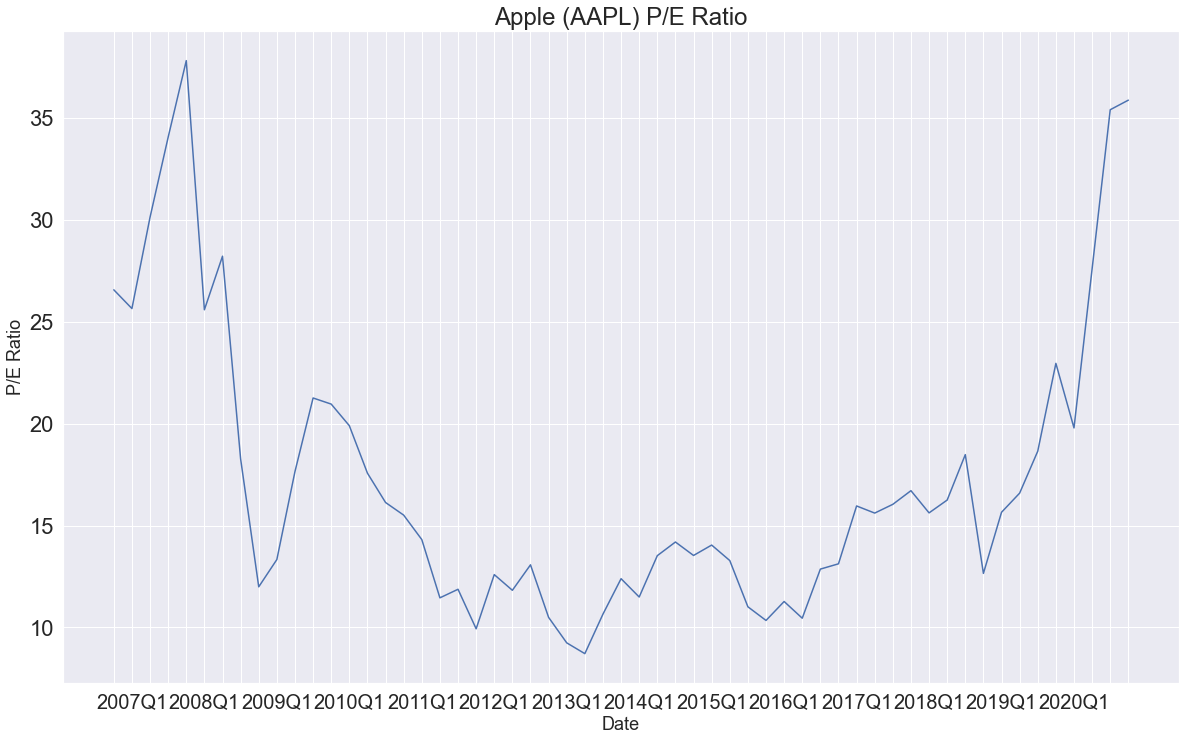

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(font_scale=2)

# plot P/E ratio, x-axis are quarters
x = np.arange(0,len(df_joined),1)
fig, ax = plt.subplots(1,1)
ax.plot(x,df_joined['pe-ratio'])
ax.set_xticks(x)

plt.title('Apple (AAPL) P/E Ratio')
plt.xlabel('Date',fontsize=18)
plt.ylabel('P/E Ratio',fontsize=18)
plt.xticks(range(len(df_joined['pe-ratio'])), df_joined['date'], size='small')
fig.set_size_inches(20, 12)
ax.set_xticklabels(df_joined['date'])

# only show every 4th x-tick
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 4 != 1:
        label.set_visible(False)
    
plt.show()

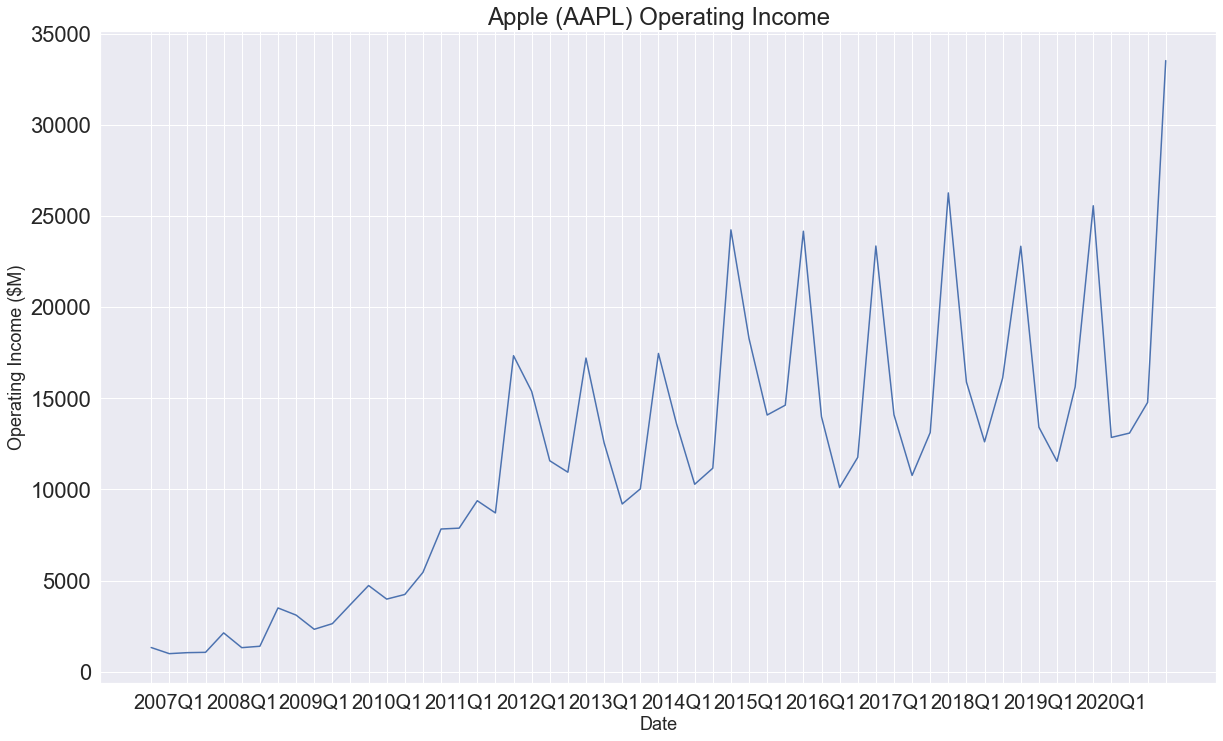

In [8]:
sns.set(font_scale=2)

# plot P/E ratio, x-axis are quarters
x = np.arange(0,len(df_joined),1)
fig, ax = plt.subplots(1,1)
ax.plot(x,df_joined['operating-income (Millions of US $)'])
ax.set_xticks(x)

plt.title('Apple (AAPL) Operating Income')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Operating Income ($M)',fontsize=18)

plt.xticks(range(len(df_joined['operating-income (Millions of US $)'])), df_joined['date'], size='small')
fig.set_size_inches(20, 12)
ax.set_xticklabels(df_joined['date'])

# only show every 4th x-tick
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 4 != 1:
        label.set_visible(False)
    
plt.show()

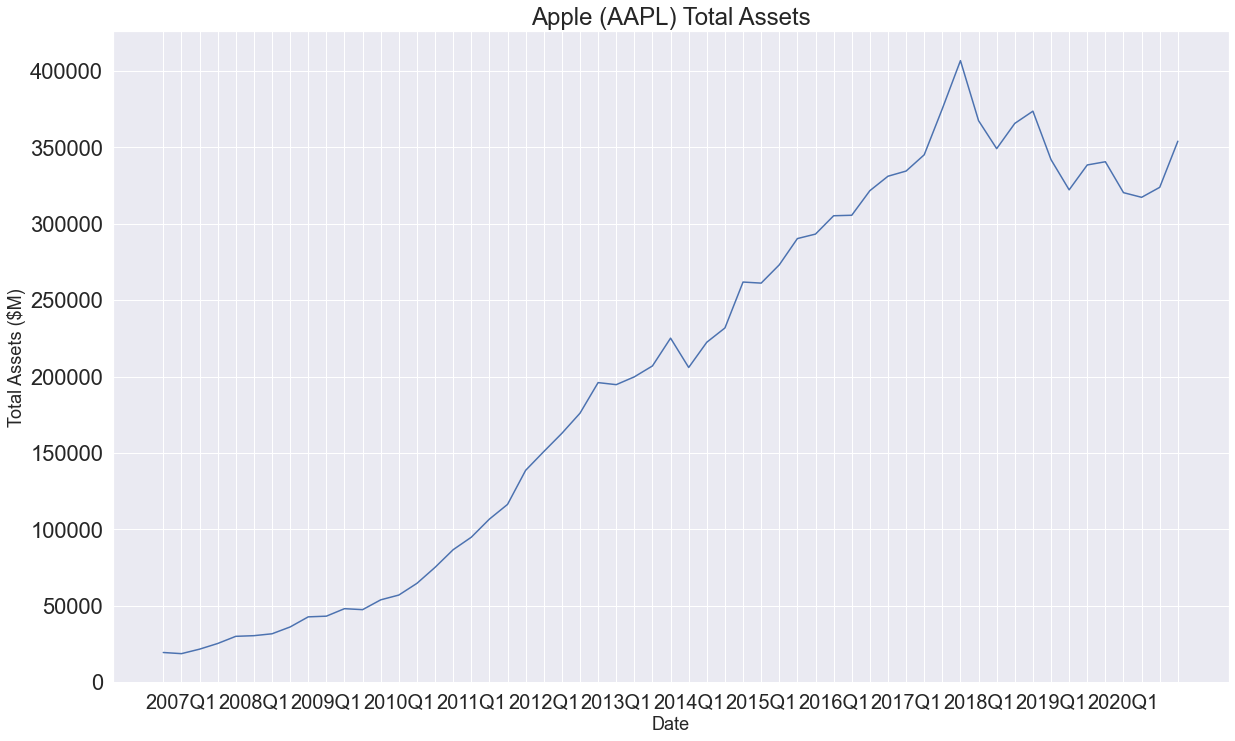

In [9]:
sns.set(font_scale=2)

x = np.arange(0,len(df_joined),1)
fig, ax = plt.subplots(1,1)
ax.plot(x,df_joined['total-assets (Millions of US $)'])
ax.set_xticks(x)

plt.title('Apple (AAPL) Total Assets')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Total Assets ($M)',fontsize=18)
plt.xticks(range(len(df_joined['total-assets (Millions of US $)'])), df_joined['date'], size='small')
fig.set_size_inches(20, 12)
ax.set_xticklabels(df_joined['date'])

# only show every 4th x-tick
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 4 != 1:
        label.set_visible(False)
    
plt.show()

<ipython-input-10-615ddccbf3a8>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_joined['pe-ratio'])


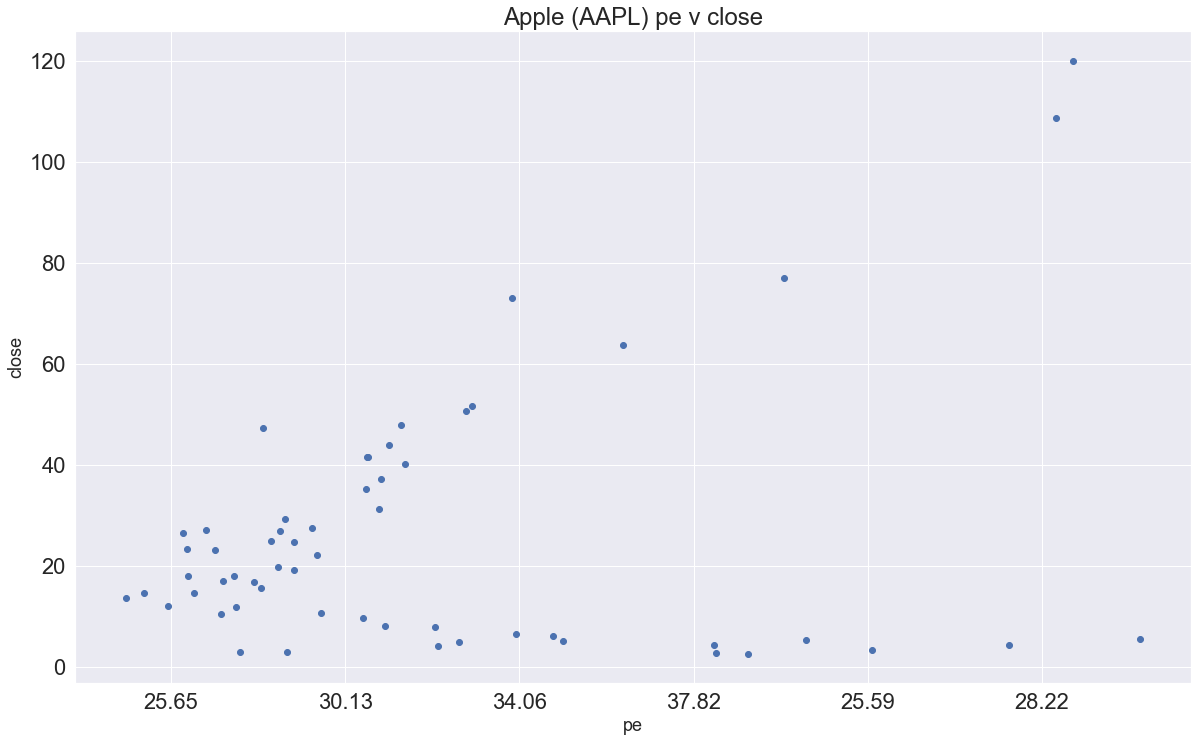

In [10]:
import matplotlib.pyplot as plt

sns.set(font_scale=2)

#x = np.arange(0,len(df_joined),1)
fig, ax = plt.subplots(1,1)
ax.scatter(df_joined['pe-ratio'], df_joined['Close'])
#ax.set_xticks(x)

plt.title('Apple (AAPL) pe v close')
plt.xlabel('pe',fontsize=18)
plt.ylabel('close',fontsize=18)
# plt.xticks(range(len(df_joined['total-assets (Millions of US $)'])), df_joined['date'], size='small')
fig.set_size_inches(20, 12)
ax.set_xticklabels(df_joined['pe-ratio'])

plt.show()

In [14]:
# fig = px.scatter(data_frame=df_joined, x='operating-income (Millions of US $)', y='Close', hover_data=df_joined.columns)
# fig.show()

# Regression

## sklearn and linear regression

This is just an example, but we could use the linear regression model in the sklearn kit. I don't know how exactly we'll do the regression, since their multiple factors and it's non linear. 

In [15]:
import pandas
from sklearn import linear_model

X = df_joined[['pe-ratio', 'operating-income (Millions of US $)']]
y = df_joined['Close']

regr = linear_model.LinearRegression()
regr.fit(X, y)

predicted_price = regr.predict([[15, 20000]])
predicted_price

array([43.52253478])

In [16]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

x = df_joined[['operating-income (Millions of US $)','total-assets (Millions of US $)','pe-ratio']]
y = df_joined['Close']

# train the model
rfr.fit(x, y)

# predict on test data
predicted = rfr.predict(np.array([350000,200000,25]).reshape(1, 3))
predicted

array([22.45410597])

# Visualization of Random Forest Regression Results

<AxesSubplot:>

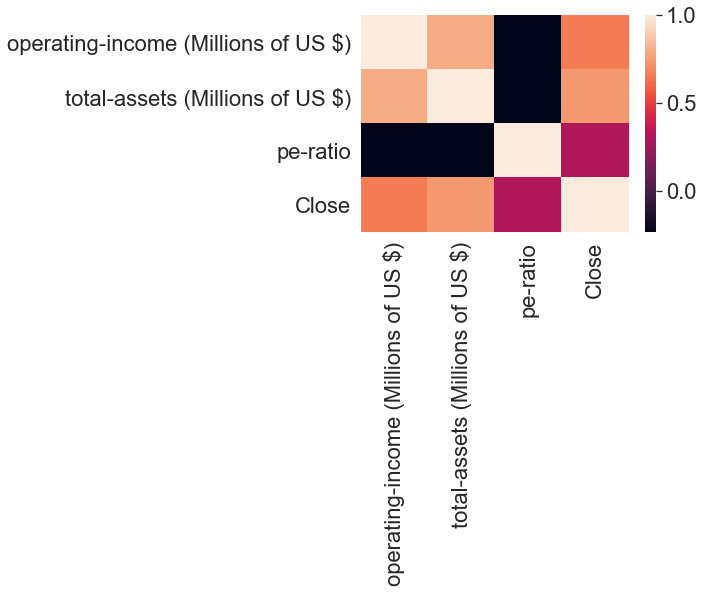

In [17]:
sns.heatmap(df_joined.corr())

Our project will rely heavily on the Price/Earnings (PE) ratio in order to determine the value of a stock of a company. 

In most cases, the PE ratio is used to determine if a stock price is overvalued or undervalued for the sector that it belongs to. By comparing PE ratios between companies of the same sector, it is easy to see what a fair market value for the stock is.

This is critical as this project aims to predict future prices for a stock share through logical regression. We want to determine if the stock price will go up or down from what it is currently at a given point in the future.

The PE ratio can then be used in conjunction with the historical prices of the stock in order to determine correlation as well as if future prices are going to go up or down. 

In order to account for how far into the future we want to look for a particular stock price, the number of historical prices observed can be adjusted to for more long term growth predictions.